# Resources

https://data-flair.training/blogs/python-project-traffic-signs-recognition/
https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


## Current status
- VGG, Resnet, based on https://www.kaggle.com/code/hivasi/augmentation-adam-optimiser-vgg-baseline
- EfficientNet, based on https://www.kaggle.com/code/sounaksarkar/german-traffic-sign-benchmark-classification

# Setup

## Load libraries

In [2]:
import datetime
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2
from PIL import Image
from tensorflow.python import summary

## Load extensions

In [6]:
# Display matplotlib plots inline
%matplotlib inline

try:
    # Format tables printed to the screen (don't put comment on the same line as the
    %load_ext google.colab.data_table
except:
    print("Cannot load 'google.colab.data_table' extension")

# Load the TensorBoard notebook extension
%load_ext tensorboard

Cannot load 'google.colab.data_table' extension
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load and process data

## Initialize variables

Initialize global variables and set seed for keras related libraries

In [7]:
data_dir = '.'
IMG_HEIGHT = 60
IMG_WIDTH = 60
IMAGE_SHAPE=(IMG_HEIGHT, IMG_WIDTH)
SEED = 19121
tf.keras.utils.set_random_seed(SEED)

## Load images metadata

Adding traffic sign name to the loaded CSVs

In [57]:
import pandas as pd
class_names = pd.read_csv('class_names.csv').set_index('ClassId')
df = pd.read_csv('Train.csv').join(class_names, on='ClassId', how='left')
df_test = pd.read_csv('Test.csv').join(class_names, on='ClassId', how='left')
meta = pd.read_csv('Meta.csv').join(class_names, on='ClassId', how='left')
NUM_CLASSES = class_names.shape[0]
NUM_CLASSES

43

## Dispay sample images

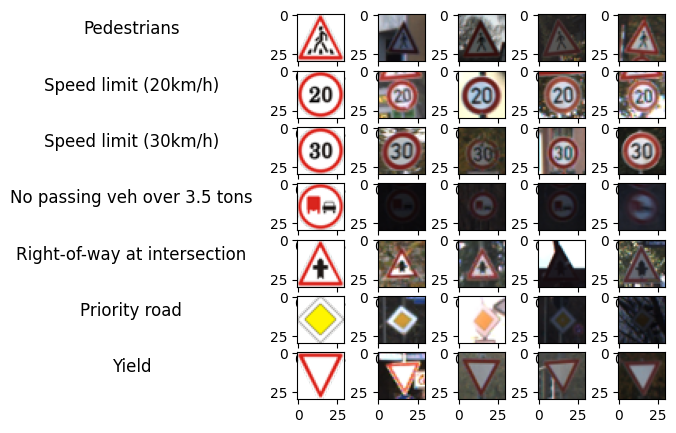

In [130]:
SAMPLE_SIGNS=7
SAMPLE_TRAINS=4
fig = plt.figure(figsize = (5,5))
plt.tight_layout()

idx = 0
for i in range(SAMPLE_SIGNS):
    idx += 1
    class_id = meta['ClassId'][i]
    label = meta['TrafficSign'][i]
    image = Image.open(meta['Path'][i])
    image = image.resize((30,30))
    ax = plt.subplot(SAMPLE_SIGNS, SAMPLE_TRAINS+1, idx)
    ax.set_ylabel(label, rotation=0, size='large', labelpad=100)
    plt.imshow(image)
    class_train = df[df['ClassId']==class_id]
    for j in range(SAMPLE_TRAINS):
        idx += 1
        image = Image.open(class_train.sample()['Path'].values[0])
        image = image.resize((30,30))
        plt.subplot(SAMPLE_SIGNS, SAMPLE_TRAINS+1, idx)
        plt.imshow(image)

plt.show()


## Load Images

In [2]:
# load and iterate training dataset
train_df = tf.keras.utils.load_images_from_directory(f'${data_dir}/Train/', class_mode='binary', batch_size=64, subset='training')
val_df = tf.keras.utils.load_images_from_directory(f'${data_dir}/Train/', class_mode='binary', batch_size=64, subset='validation')

# load and iterate test dataset
test_df = tf.keras.utils.load_images_from_directory(f'{data_dir}/Test/', class_mode='binary', batch_size=64)

# load meta dataset to display actual sign drawings
meta_df = tf.keras.utils.load_images_from_directory(f'{data_dir}/Meta/', class_mode='binary', batch_size=64)

Traffic Sign: 20 - Dangerous curve right


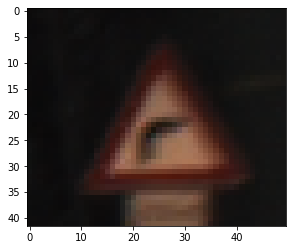

In [ ]:
s = df.sample()
class_id = s['ClassId'].item()
image_path = s['Path'].item()
img = Image.open(os.path.join(data_dir, image_path))
print(f'Traffic Sign: {class_id} - {CLASS_NAMES[class_id]}')
plt.imshow(img)

In [ ]:
from fastprogress import master_bar, progress_bar

# Reading the input images and putting them into a numpy array
image_data=[]
image_labels=[]

channels = 3
n_inputs = IMG_HEIGHT * IMG_WIDTH * channels

mb = master_bar(range(NUM_CLASSES))
for i in mb:
    parent_path = f"{data_dir}/Train/{i}/"
    class_images=os.listdir(parent_path)
    for image_name in progress_bar(class_images, parent=mb):
      image_path = parent_path+image_name
      mb.child.comment = f'Loading {image_path}'
      image = cv2.imread(image_path)
      image_from_array = Image.fromarray(image, 'RGB')
      size_image = image_from_array.resize((IMG_HEIGHT, IMG_WIDTH))
      image_data.append(np.array(size_image))
      image_labels.append(i)
    mb.main_bar.comment = f'Loading images for traffic sign {i} - {CLASS_NAMES[i]}'
    mb.write(f'Loaded images for traffic sign {i} - {CLASS_NAMES[i]}')
            
image_data=np.array(image_data)
image_labels=np.array(image_labels)
print(image_data.shape, image_labels.shape)

(39209, 60, 60, 3) (39209,)


## Prepare data

### Randomize the order of the input images


In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

### dividing into validation and training

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

y_train = tf.keras.utils.to_categorical(y_train,NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)

In [ ]:
print("X_train", X_train.shape)
print("X_valid", X_val.shape)
print("y_train", y_train.shape)
print("y_valid", y_val.shape)

X_train (27446, 60, 60, 3)
X_valid (11763, 60, 60, 3)
y_train (27446, 43)
y_valid (11763, 43)


# VGG + Adam Optimizer

In [ ]:
learning_rate = 0.0003
epochs = 15
opt = Adam(learning_rate=learning_rate)

In [ ]:
def test_acc():
    test = pd.read_csv(data_dir + '/Test.csv')
    labels = test["ClassId"].values
    imgs = test["Path"].values
    data =[]
    for img in imgs:
        try:
            image = cv2.imread(data_dir + '/' +img)
            image_fromarray = Image.fromarray(image,'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            data.append(np.array(resize_image))
        except:
            print("Error in " + img)
            
    X_test = np.array(data)

    X_test = X_test/255
    
    return X_test, labels

In [ ]:
# Get pretrained model

pretrained_model= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                   #pooling='avg',
                   weights='imagenet')

vgg_model_unfreeze_2block = Sequential()
pretrained_model.trainable = True
for layer in pretrained_model.layers[:12]:
    layer.trainable = False
    
        
#for layer in pretrained_model.layers[:-1]: # go through until last layer
    #resnet_model.add(layer)
    

#resnet_model.add(tf.keras.layers.BatchNormalization(renorm=True))
vgg_model_unfreeze_2block.add(pretrained_model)
#resnet_model.add(tf.keras.layers.BatchNormalization())
vgg_model_unfreeze_2block.add(Flatten())

prediction_layer = tf.keras.layers.Dense(43, activation='softmax')
vgg_model_unfreeze_2block.add(prediction_layer)

#model.compile(optimizer='adam', loss='categorical_crossentropy')
for i, layer in enumerate(pretrained_model.layers):
        print(i, layer.name, "-", layer.trainable)

0 input_7 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_conv4 - False
11 block3_pool - False
12 block4_conv1 - True
13 block4_conv2 - True
14 block4_conv3 - True
15 block4_conv4 - True
16 block4_pool - True
17 block5_conv1 - True
18 block5_conv2 - True
19 block5_conv3 - True
20 block5_conv4 - True
21 block5_pool - True


In [ ]:
aug = ImageDataGenerator(
    horizontal_flip=True,width_shift_range=0.1,
    height_shift_range=0.1,rotation_range=20,featurewise_center=True,
    featurewise_std_normalization=True,shear_range=0.15
    )

In [ ]:
learning_rate = 0.0003
epochs = 15
opt = Adam(learning_rate=learning_rate)

In [ ]:
# Compile model
vgg_model_unfreeze_2block.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
len(vgg_model_unfreeze_2block.trainable_variables)

18

In [ ]:
vgg19_logdir = os.path.join("logs-VGG19", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_vgg19_callback = tf.keras.callbacks.TensorBoard(vgg19_logdir, histogram_freq=1)


In [ ]:
history = vgg_model_unfreeze_2block.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_val, y_val), callbacks=[tensorboard_vgg19_callback])

Epoch 1/15
215/215 [==============================] - 30s 136ms/step - loss: 0.9174 - accuracy: 0.7124 - val_loss: 0.3076 - val_accuracy: 0.8971
Epoch 2/15
215/215 [==============================] - 29s 137ms/step - loss: 0.1723 - accuracy: 0.9450 - val_loss: 0.2972 - val_accuracy: 0.9159
Epoch 3/15
215/215 [==============================] - 29s 134ms/step - loss: 0.1143 - accuracy: 0.9638 - val_loss: 0.0694 - val_accuracy: 0.9760
Epoch 4/15
215/215 [==============================] - 29s 135ms/step - loss: 0.0842 - accuracy: 0.9753 - val_loss: 0.1396 - val_accuracy: 0.9583
Epoch 5/15
215/215 [==============================] - 29s 135ms/step - loss: 0.0728 - accuracy: 0.9778 - val_loss: 0.0611 - val_accuracy: 0.9820
Epoch 6/15
215/215 [==============================] - 29s 135ms/step - loss: 0.0533 - accuracy: 0.9851 - val_loss: 0.0787 - val_accuracy: 0.9785
Epoch 7/15
215/215 [==============================] - 29s 135ms/step - loss: 0.0526 - accuracy: 0.9855 - val_loss: 0.0699 - val_ac

In [ ]:
%tensorboard --logdir "logs-VGG19"

Reusing TensorBoard on port 6006 (pid 2142), started 1:00:45 ago. (Use '!kill 2142' to kill it.)

<IPython.core.display.Javascript object>

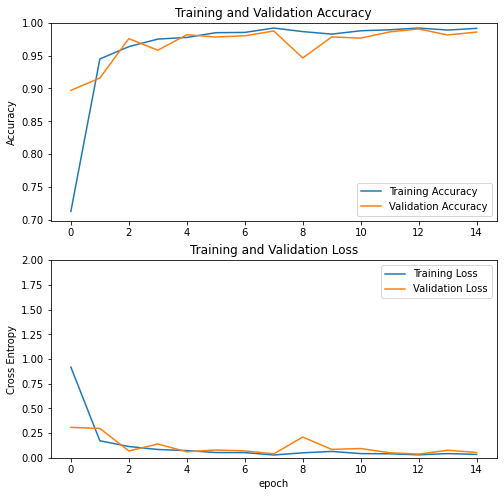

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score 
X_test, labels = test_acc()

# predict
pred_x = vgg_model_unfreeze_2block.predict(X_test)
pred=np.argmax(pred_x,axis=1)
    #Accuracy with the test data
final_acc = accuracy_score(labels, pred)*100
print(final_acc)

93.63420427553444


In [ ]:
# Check batch of images


#image_batch, label_batch = next(iter(X_train))
#feature_batch = pretrained_model(image_batch)
#print(feature_batch.shape)

In [ ]:
# Check all blocks
for i, layer in enumerate(pretrained_model.layers):
        print(i, layer.name, "-", layer.trainable)

0 input_7 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_conv4 - False
11 block3_pool - False
12 block4_conv1 - True
13 block4_conv2 - True
14 block4_conv3 - True
15 block4_conv4 - True
16 block4_pool - True
17 block5_conv1 - True
18 block5_conv2 - True
19 block5_conv3 - True
20 block5_conv4 - True
21 block5_pool - True


In [ ]:
pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 60, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 60, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 30, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 30, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 30, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 15, 15, 128)       0     

# Resnet with VGG baseline

In [ ]:
# Add classificaiton head 

# Add global avarage pooling (instead of Flatten())
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)

# Add Dense layers
dense_layer256 = tf.keras.layers.Dense(256, activation='relu')
dense_layer512 = tf.keras.layers.Dense(512, activation='relu')
dense_layer1028 = tf.keras.layers.Dense(1028, activation='relu')
prediction_layer = tf.keras.layers.Dense(43, activation='softmax')
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

In [ ]:
# Build model

pretrained_model= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                   #pooling='avg',
                   weights='imagenet')

vgg_model_unfreeze_2block = Sequential()
pretrained_model.trainable = True
for layer in pretrained_model.layers[:12]:
    layer.trainable = False


In [ ]:
resnet_model = tf.keras.Sequential([
        pretrained_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(43, activation='softmax')
    ])

In [ ]:

for i, layer in enumerate(pretrained_model.layers):
        print(i, layer.name, "-", layer.trainable)
        
print('final model')
for i, layer in enumerate(resnet_model.layers):
        print(i, layer.name, "-", layer.trainable)


0 input_8 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_conv4 - False
11 block3_pool - False
12 block4_conv1 - True
13 block4_conv2 - True
14 block4_conv3 - True
15 block4_conv4 - True
16 block4_pool - True
17 block5_conv1 - True
18 block5_conv2 - True
19 block5_conv3 - True
20 block5_conv4 - True
21 block5_pool - True
final model
0 vgg19 - True
1 batch_normalization_2 - True
2 flatten_5 - True
3 dense_27 - True
4 dense_28 - True
5 dropout_4 - True
6 dense_29 - True
7 dense_30 - True


In [ ]:
learning_rate = 0.0001
epochs = 10
opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))

In [ ]:
aug = ImageDataGenerator(
 rotation_range=10,
 zoom_range=0.15,
 width_shift_range=0.1,
 height_shift_range=0.1,
 shear_range=0.15,
 horizontal_flip=False,
 vertical_flip=False,
 fill_mode="nearest"
 )


In [ ]:
# Compile model
resnet_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_2 (Batc  (None, 1, 1, 512)        3584      
 hNormalization)                                                 
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)               262656    
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
resnet_logdir = os.path.join("logs-resnet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_resnet_callback = tf.keras.callbacks.TensorBoard(resnet_logdir, histogram_freq=1)

In [ ]:
history = resnet_model.fit(X_train, y_train, batch_size=256, epochs=epochs, validation_data=(X_val, y_val), callbacks=[tensorboard_resnet_callback])

Epoch 1/10
108/108 [==============================] - 30s 266ms/step - loss: 1.8403 - accuracy: 0.5559 - val_loss: 0.3935 - val_accuracy: 0.9130
Epoch 2/10
108/108 [==============================] - 27s 255ms/step - loss: 0.2455 - accuracy: 0.9466 - val_loss: 0.0910 - val_accuracy: 0.9716
Epoch 3/10
108/108 [==============================] - 27s 254ms/step - loss: 0.1003 - accuracy: 0.9743 - val_loss: 0.0463 - val_accuracy: 0.9855
Epoch 4/10
108/108 [==============================] - 27s 254ms/step - loss: 0.0621 - accuracy: 0.9823 - val_loss: 0.0570 - val_accuracy: 0.9852
Epoch 5/10
108/108 [==============================] - 28s 255ms/step - loss: 0.0421 - accuracy: 0.9894 - val_loss: 0.0375 - val_accuracy: 0.9888
Epoch 6/10
108/108 [==============================] - 27s 254ms/step - loss: 0.0295 - accuracy: 0.9918 - val_loss: 0.0385 - val_accuracy: 0.9901
Epoch 7/10
108/108 [==============================] - 27s 254ms/step - loss: 0.0263 - accuracy: 0.9925 - val_loss: 0.0275 - val_ac

In [ ]:
%tensorboard --logdir "logs-resnet"

Reusing TensorBoard on port 6007 (pid 2345), started 0:59:47 ago. (Use '!kill 2345' to kill it.)

<IPython.core.display.Javascript object>

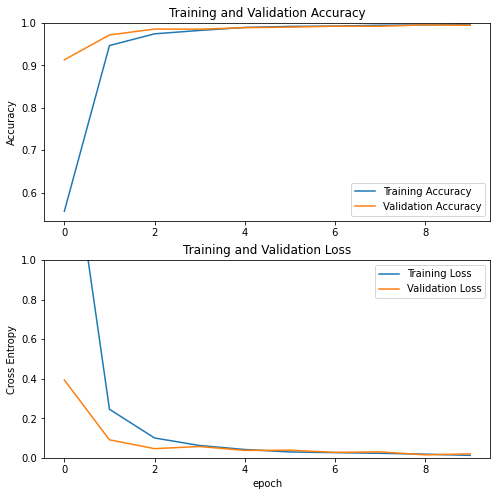

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def test_acc():
    test = pd.read_csv(data_dir + '/Test.csv')
    labels = test["ClassId"].values
    imgs = test["Path"].values
    data =[]
    for img in imgs:
        try:
            image = cv2.imread(data_dir + '/' +img)
            image_fromarray = Image.fromarray(image,'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            data.append(np.array(resize_image))
        except:
            print("Error in " + img)
            
    X_test = np.array(data)

    X_test = X_test/255
    
    return X_test, labels

In [ ]:
X_test, labels = test_acc()

# predict
pred_x = resnet_model.predict(X_test)
pred=np.argmax(pred_x,axis=1)

#Accuracy with the test data
final_acc = accuracy_score(labels, pred)*100
print(final_acc)

93.89548693586698


# EfficientNet

In [ ]:
!pip install efficientnet --quiet

In [ ]:
from efficientnet.tfkeras import EfficientNetB0
base_model_efn = EfficientNetB0(include_top=False,weights="imagenet",input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), pooling='max')

In [ ]:
x_efn=base_model_efn.output
base_model_efn.trainable=False

In [ ]:
from tensorflow.keras.models import Model

x_efn=Dense(256,activation='relu')(x_efn)
x_efn=Dropout(rate=.45,seed=123)(x_efn)   
output_efn=Dense(NUM_CLASSES,activation='softmax')(x_efn)
model_efn=Model(inputs=base_model_efn.input,outputs=output_efn)
model_efn.compile(Adam(learning_rate=.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=30
logdir_efn = os.path.join("logs-efficientnet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback_efn = tf.keras.callbacks.TensorBoard(logdir_efn, histogram_freq=1)
rlronp_efn=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=1,verbose=1)
estop_efn=tf.keras.callbacks.EarlyStopping( monitor="val_loss",patience=3,verbose=1,restore_best_weights=True)
history_efn=model_efn.fit(
    x=X_train, 
    y=y_train, 
    epochs=epochs, 
    verbose=1, 
    validation_data=(X_val, y_val), 
    callbacks=[rlronp_efn, estop_efn, tensorboard_callback_efn], 
    shuffle=True, 
    initial_epoch=0
)

Epoch 1/30
858/858 [==============================] - 23s 21ms/step - loss: 1.7361 - accuracy: 0.4762 - val_loss: 1.0245 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 2/30
858/858 [==============================] - 16s 19ms/step - loss: 1.1351 - accuracy: 0.6307 - val_loss: 0.7703 - val_accuracy: 0.7514 - lr: 0.0010
Epoch 3/30
858/858 [==============================] - 16s 19ms/step - loss: 0.9531 - accuracy: 0.6861 - val_loss: 0.6642 - val_accuracy: 0.7862 - lr: 0.0010
Epoch 4/30
858/858 [==============================] - 16s 19ms/step - loss: 0.8424 - accuracy: 0.7217 - val_loss: 0.6002 - val_accuracy: 0.8081 - lr: 0.0010
Epoch 5/30
858/858 [==============================] - 16s 19ms/step - loss: 0.7700 - accuracy: 0.7440 - val_loss: 0.5312 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 6/30
858/858 [==============================] - 16s 19ms/step - loss: 0.7166 - accuracy: 0.7605 - val_loss: 0.4877 - val_accuracy: 0.8374 - lr: 0.0010
Epoch 7/30
858/858 [==============================] - 16s 

In [ ]:
%tensorboard --logdir "logs-efficientnet"